<a href="https://colab.research.google.com/github/jeIIycodes/HackUSF-2025/blob/main/HackUSF_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import cv2
import matplotlib.pyplot as plt
from google.colab import files

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold # new

In [4]:
from tensorflow import keras
from tensorflow.keras.models import load_model

In [22]:
if not os.path.exists('model'):
    os.makedirs('model')

In [8]:
!curl -L -o ./skin-cancer-malignant-vs-benign.zip\
  https://www.kaggle.com/api/v1/datasets/download/fanconic/skin-cancer-malignant-vs-benign

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  324M  100  324M    0     0  19.8M      0  0:00:16  0:00:16 --:--:-- 21.9M


In [9]:
!unzip skin-cancer-malignant-vs-benign.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/benign/420.jpg  
  inflating: data/train/benign/421.jpg  
  inflating: data/train/benign/422.jpg  
  inflating: data/train/benign/423.jpg  
  inflating: data/train/benign/424.jpg  
  inflating: data/train/benign/425.jpg  
  inflating: data/train/benign/426.jpg  
  inflating: data/train/benign/429.jpg  
  inflating: data/train/benign/43.jpg  
  inflating: data/train/benign/430.jpg  
  inflating: data/train/benign/431.jpg  
  inflating: data/train/benign/432.jpg  
  inflating: data/train/benign/434.jpg  
  inflating: data/train/benign/435.jpg  
  inflating: data/train/benign/438.jpg  
  inflating: data/train/benign/439.jpg  
  inflating: data/train/benign/440.jpg  
  inflating: data/train/benign/441.jpg  
  inflating: data/train/benign/442.jpg  
  inflating: data/train/benign/443.jpg  
  inflating: data/train/benign/445.jpg  
  inflating: data/train/benign/446.jpg  
  inflating: data/train/benign/447.jpg  
  infla

In [10]:
train_dir = 'train'
os.listdir(train_dir)

['malignant', 'benign']

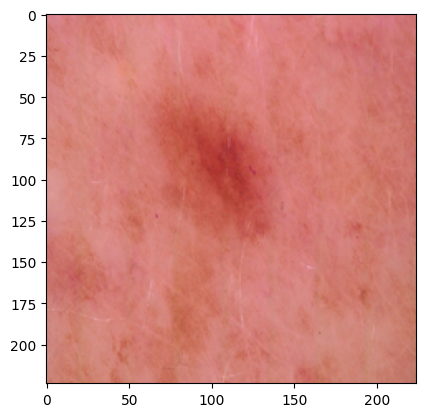

In [11]:
ex_image = cv2.imread(os.path.join(train_dir, 'benign', '91.jpg'))
ex_image = cv2.cvtColor(ex_image, cv2.COLOR_BGR2RGB)
plt.imshow(ex_image)
plt.show()

In [12]:
print(ex_image.shape)

(224, 224, 3)


In [13]:
full_dataset = tf.keras.utils.image_dataset_from_directory(
    'train',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,   # Shuffle to ensure random distribution for K-fold
    seed=42
)

Found 2637 files belonging to 2 classes.


In [14]:
def preprocess_and_augment(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, max_delta=0.1)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

def preprocess_basic(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

In [15]:
full_dataset = full_dataset.map(preprocess_basic)

In [16]:
X_list, y_list = [], []
for batch_images, batch_labels in full_dataset:
    X_list.append(batch_images)
    y_list.append(batch_labels)

X = tf.concat(X_list, axis=0).numpy()
y = tf.concat(y_list, axis=0).numpy()

print("Total samples:", X.shape[0])

Total samples: 2637


In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [26]:
fold_no = 1
for train_index, val_index in kf.split(X):
    print(f"\n--- Fold {fold_no} ---")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Build the CNN
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    model.summary()

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=25,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )

    model.save(f'model/model_fold_{fold_no}.h5') # save the model

    # For each fold: evaluate/ save the model
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold_no} — Validation Loss: {scores[0]:.4f}, Validation Accuracy: {scores[1]:.4f}")

    fold_no += 1


--- Fold 1 ---


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,905 (91.20 MB)

 Trainable params: 23,907,713 (91.20 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.6824 - loss: 24.1900 - val_accuracy: 0.5701 - val_loss: 21.4844
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.6915 - loss: 0.8216 - val_accuracy: 0.5701 - val_loss: 47.3396
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7456 - loss: 0.5033 - val_accuracy: 0.5701 - val_loss: 73.4180
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.7474 - loss: 0.4764 - val_accuracy: 0.5777 - val_loss: 67.1297


Fold 1 — Validation Loss: 67.1297, Validation Accuracy: 0.5777

--- Fold 2 ---


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,905 (91.20 MB)

 Trainable params: 23,907,713 (91.20 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.6814 - loss: 23.9017 - val_accuracy: 0.4943 - val_loss: 6.2805
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7149 - loss: 0.6104 - val_accuracy: 0.5095 - val_loss: 10.8433
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7330 - loss: 0.5395 - val_accuracy: 0.6269 - val_loss: 6.8140
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7187 - loss: 0.4986 - val_accuracy: 0.6686 - val_loss: 7.5909


Fold 2 — Validation Loss: 7.5909, Validation Accuracy: 0.6686

--- Fold 3 ---


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,905 (91.20 MB)

 Trainable params: 23,907,713 (91.20 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.6951 - loss: 24.0808 - val_accuracy: 0.6850 - val_loss: 2.3217
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6880 - loss: 0.7918 - val_accuracy: 0.7249 - val_loss: 5.1263
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.6366 - loss: 0.6180 - val_accuracy: 0.7647 - val_loss: 6.6400
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7248 - loss: 0.5427 - val_accuracy: 0.7761 - val_loss: 8.2573


Fold 3 — Validation Loss: 8.2573, Validation Accuracy: 0.7761

--- Fold 4 ---


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,905 (91.20 MB)

 Trainable params: 23,907,713 (91.20 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.6820 - loss: 18.8833 - val_accuracy: 0.5787 - val_loss: 11.8553
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7099 - loss: 1.3883 - val_accuracy: 0.4364 - val_loss: 17.6982
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7663 - loss: 0.5043 - val_accuracy: 0.4763 - val_loss: 19.7079
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7783 - loss: 0.4825 - val_accuracy: 0.7078 - val_loss: 10.0807
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7401 - loss: 0.5398 - val_accuracy: 0.7419 - val_loss: 11.1176
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7836 - loss: 0.4826 - val_accuracy: 0.6660 - val_loss: 20.7614
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7943 - loss: 0.4671 - val_accuracy: 0.7666 - val_loss: 11.6361


Fold 4 — Validation Loss: 11.6361, Validation Accuracy: 0.7666

--- Fold 5 ---


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,905 (91.20 MB)

 Trainable params: 23,907,713 (91.20 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.6685 - loss: 22.3582 - val_accuracy: 0.7040 - val_loss: 2.3635
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6996 - loss: 1.8656 - val_accuracy: 0.4706 - val_loss: 17.6322
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7276 - loss: 0.5542 - val_accuracy: 0.4687 - val_loss: 26.3734
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7313 - loss: 0.4574 - val_accuracy: 0.5484 - val_loss: 16.5969


Fold 5 — Validation Loss: 16.5969, Validation Accuracy: 0.5484


In [27]:
model5 = load_model('model/model_fold_5.h5')

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# test the model
loss, acc = model5.evaluate(X, y, batch_size=32)
print(f"Model 5 — Accuracy: {acc:.4f}, Loss: {loss:.4f}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5515 - loss: 15.6677
Model 5 — Accuracy: 0.5484, Loss: 15.9525


# Server (Backend API)

In [ ]:
model5 = load_model('model/model_fold_5.h5')

# Other code

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    'train',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val = tf.keras.utils.image_dataset_from_directory(
    'train',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

test = tf.keras.utils.image_dataset_from_directory(
    'test',
    image_size=(224, 224),
    batch_size=32
)

Found 2637 files belonging to 2 classes.
Using 2110 files for training.
Found 2637 files belonging to 2 classes.
Using 527 files for validation.
Found 660 files belonging to 2 classes.


In [ ]:
def preprocess_and_augment(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, max_delta=0.1)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

In [ ]:
def preprocess_basic(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

In [ ]:
train = train.map(preprocess_and_augment)
val = val.map(preprocess_basic)
test = test.map(preprocess_basic)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,905 (91.20 MB)

 Trainable params: 23,907,713 (91.20 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
model.fit(train, epochs=15, validation_data=val, callbacks=[early_stop])

Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7517 - loss: 1.3921 - val_accuracy: 0.4687 - val_loss: 12.7542
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.7421 - loss: 0.5735 - val_accuracy: 0.4668 - val_loss: 29.4254
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7488 - loss: 0.5572 - val_accuracy: 0.5920 - val_loss: 10.5170
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.7559 - loss: 0.5204 - val_accuracy: 0.5560 - val_loss: 17.9859
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.7682 - loss: 0.4757 - val_accuracy: 0.5598 - val_loss: 24.6219
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7703 - loss: 0.4601 - val_accuracy: 0.7059 - val_loss: 10.2973
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.7646 - loss: 0.4607 - val_accuracy: 0.7268 - val_loss: 7.8309
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.7629 - loss: 0.4408 - val_accuracy: 0.71